In [ ]:
! git clone https://github.com/roshanr11/image-captioning.git

Cloning into 'image-captioning'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 55 (delta 0), reused 1 (delta 0), pack-reused 53
Unpacking objects: 100% (55/55), 191.16 MiB | 4.33 MiB/s, done.
Updating files: 100% (25/25), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset


In [ ]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
%cd image-captioning
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,
                         batch_size = 1,
                         mode='test')

[Errno 2] No such file or directory: 'image-captioning'
/content/image-captioning
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


Run the code cell below to visualize an example test image, before pre-processing is applied.

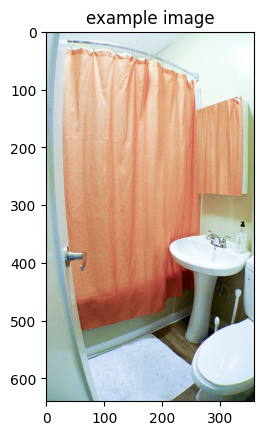

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Watch for any changes in model.py, and re-load it automatically.
"""% load_ext autoreload
% autoreload 2"""

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.1MB/s]


DecoderRNN(
  (word_embedding_layer): Embedding(9955, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear_fc): Linear(in_features=512, out_features=9955, bias=True)
)

In [ ]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list"
assert all([type(x)==int for x in output]), "Output should be a list of integers."
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 10, 21, 3, 57, 6, 3, 56, 1]


In [ ]:
# TODO #4: Complete the function.
def clean_sentence(output):
    sentence = ''
    new_output = output[1:-1] # discard start and end tokens
    for i in range(len(new_output)):
        curr_token = new_output[i]
        if curr_token == 18: sentence += data_loader.dataset.vocab.idx2word[curr_token]
        else: sentence += ' ' + data_loader.dataset.vocab.idx2word[curr_token]
    return sentence


In [ ]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence:  a bathroom with a toilet and a sink


In [ ]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output)
    print(sentence)


In [ ]:
count = 0
new_results = []
with torch.no_grad():
    for ids, images in data_loader:
        count += 1
        print("{}/{}".format(count, len(data_loader)))
        images = images.to(device)
        features = encoder(images).unsqueeze(1)
        output = decoder.sample(features)
        sentence = clean_sentence(output)
        new_results.append({
        "image_id": ids.item(),
        "caption": sentence
    })



In [ ]:
import json
with open("cnn_lstm_coco_cap_4.json", "w") as f:
    json.dump(new_results, f)

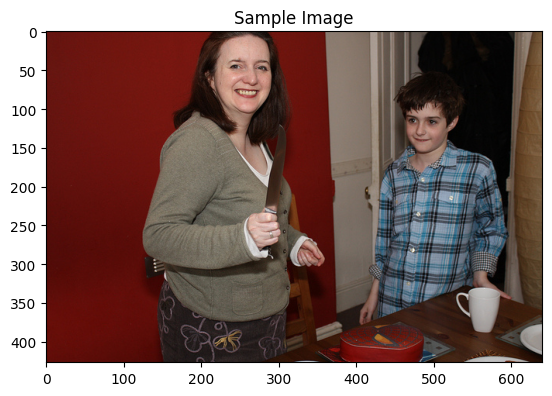

 a man and a woman are playing video games together.


In [ ]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

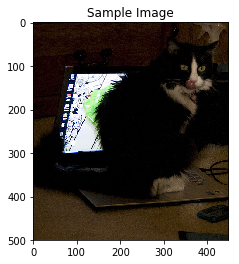

 a cat is sitting on a desk with a computer.


In [ ]:
get_prediction()

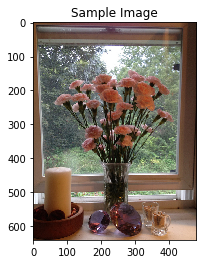

 a vase with flowers in it sitting on a table


In [ ]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

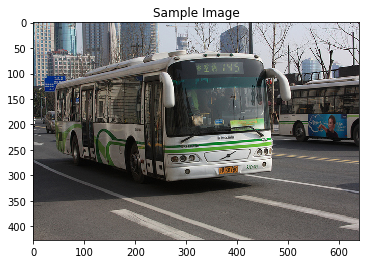

 a bus parked in a parking lot next to a building


In [ ]:
get_prediction()

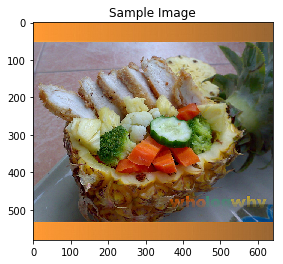

 a plate of food with a fork and knife


In [ ]:
get_prediction()